In [1]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py as h5

In [2]:
sys.path.append("../..")

In [3]:
from source.NAHEA_CNN import NAHEA_CNN_1

In [12]:
# load data from sin dataset
data_save_dir = Path("../../data") / "sin_trend"
data_save_path_train = data_save_dir / "train.h5"
data_save_path_test = data_save_dir / "test.h5"

with h5.File(data_save_path_train, "r") as f:
    X_train = f["X"][:].squeeze(2)
    y_train = f["y"][:]

with h5.File(data_save_path_test, "r") as f:
    X_test = f["X"][:].squeeze(2)
    y_test = f["y"][:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4000, 21)
y_train shape: (4000, 4)
X_test shape: (1000, 21)
y_test shape: (1000, 4)


In [13]:
n_train = 150
n_test = 500 # testing is much faster than training
X_train = X_train[:n_train]
y_train = y_train[:n_train][:, :2] # freq, slope, intercept, phase. Only predict freq and slope
X_test = X_test[:n_test]
y_test = y_test[:n_test][:, :2]

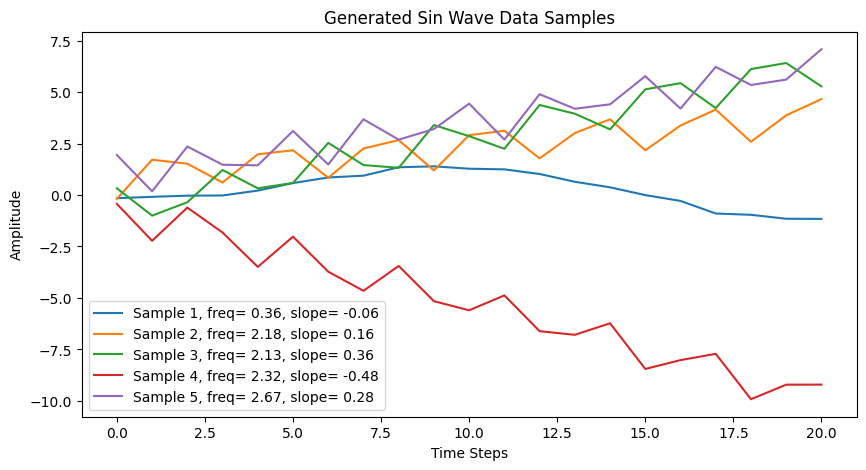

In [14]:
# plot some data
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(X_train[i], label=f"Sample {i+1}, freq= {y_train[i][0]:.2f}, slope= {y_train[i][1]:.2f}")
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

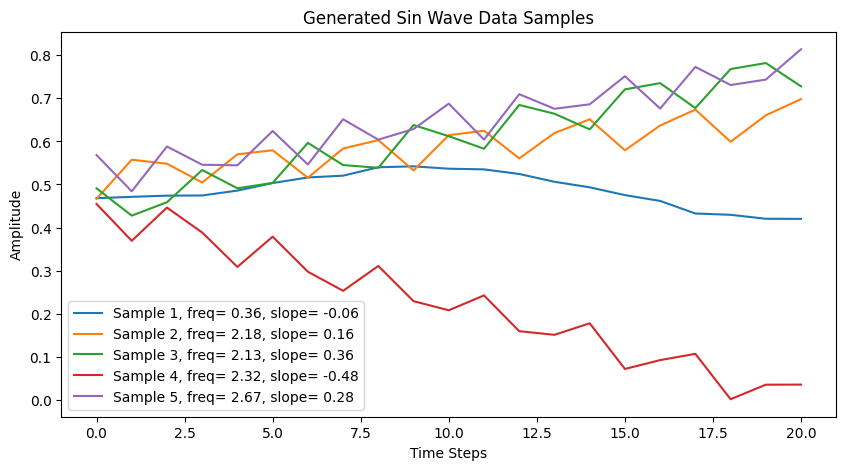

In [15]:
# normalize data to [0, 1]
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

# plot some data
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(X_train[i], label=f"Sample {i+1}, freq= {y_train[i][0]:.2f}, slope= {y_train[i][1]:.2f}")
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [8]:
seq_len = X_train.shape[1]
hparams = {
    "n_features": (n_features := 5),  # =1D kernel size = number of qubits
    "sampling_rate": 0.2,
    "protocol": "min-delay",
    "n_ancilliary_qubits": (n_ancilliary_qubits := 0), # not implemented
    "input_length": seq_len,
    "stride": 4,  # stride for the convolution
    "output_dim": 2,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
}

sep = 7.0
parameters = {
    # separation of 7 between the qubits
    "positions": [[sep * i - (sep * 2), 0] for i in range(n_features)],
    "local_pulses_omega_1": [0.5, 1.0, 1.5, 1.0, 0.5],
    "local_pulses_delta_1": [0.0] * n_features,
    "global_pulse_omega_1": 1.0,
    "global_pulse_delta_1": 0.0,
    "global_pulse_omega_2": 0.5,
    "global_pulse_delta_2": 0.0,
    "global_pulse_duration": 100,
    "local_pulse_duration": 80,
    "embed_pulse_duration": 80,
}


NAHEA_CNN = NAHEA_CNN_1(
    hparams=hparams, parameters=parameters, name="NAHEA_CNN_2"
)

# set some parameters to not require gradients. They didn't change much last time
NAHEA_CNN._parameters["positions"].requires_grad = False
NAHEA_CNN._parameters["local_pulses_delta_1"].requires_grad = False
NAHEA_CNN._parameters["global_pulse_delta_1"].requires_grad = False
NAHEA_CNN._parameters["global_pulse_delta_2"].requires_grad = False

Final FC NN: Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=2, bias=True)
)
Adding parameter 0.weight to model
Adding parameter 0.bias to model
Adding parameter 2.weight to model
Adding parameter 2.bias to model
Adding parameter 4.weight to model
Adding parameter 4.bias to model


In [9]:
y_train.shape

(150, 2)

In [10]:
# train the model
batch_size = 16
epochs = 20
loss_hist = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
NAHEA_CNN.train()
print(f"{NAHEA_CNN.parameters()}")
optimizer = torch.optim.Adam(
    [param for _, param in NAHEA_CNN.parameters().items() if param.requires_grad],
    lr=0.01,
    weight_decay=1e-5,
)
params_hist = [copy.deepcopy(NAHEA_CNN.parameters())]
for epoch in range(epochs):
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64)
        y_batch = torch.tensor(
            y_train[i : i + batch_size, :2], dtype=torch.float64 # only predict peak positions
        )
        batch_out = [NAHEA_CNN.forward(xx, dist_grad=True) for xx in x_batch]
        predicted = torch.stack([bo["output"] for bo in batch_out])
        loss = loss_fn(predicted, y_batch)
        tqdm.write(
            f"Batch {i // batch_size + 1} loss: {loss.item():.4f}, "
            f"RMSE: {np.sqrt(loss.item()):.4f}"
        )
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append(copy.deepcopy(NAHEA_CNN.parameters()))
    epoch_loss = np.mean(epoch_losses)
    tqdm.write(f"Epoch {epoch+1} train loss: {epoch_loss}")
loss_hist = np.array(loss_hist)
print(f"Final loss: {loss_hist[-1]}")
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")

{'positions': tensor([[-14.,   0.],
        [ -7.,   0.],
        [  0.,   0.],
        [  7.,   0.],
        [ 14.,   0.]]), 'local_pulses_omega_1': tensor([0.5000, 1.0000, 1.5000, 1.0000, 0.5000], requires_grad=True), 'local_pulses_delta_1': tensor([0., 0., 0., 0., 0.]), 'global_pulse_omega_1': tensor(1., requires_grad=True), 'global_pulse_delta_1': tensor(0.), 'global_pulse_omega_2': tensor(0.5000, requires_grad=True), 'global_pulse_delta_2': tensor(0.), 'global_pulse_duration': tensor(100.), 'local_pulse_duration': tensor(80.), 'embed_pulse_duration': tensor(80.), 'conv_params': tensor([0.0913, 0.0409, 0.0149, 0.0531, 0.0440, 0.0617, 0.0489, 0.0411, 0.0486,
        0.0158, 0.0213, 0.0504, 0.0393, 0.0312, 0.0648, 0.0733, 0.0115, 0.0533,
        0.0447, 0.0436, 0.0144, 0.0569, 0.0436, 0.0056, 0.0374, 0.0259, 0.0500,
        0.0276, 0.0142, 0.0378, 0.0410, 0.0340], dtype=torch.float64,
       requires_grad=True), '0.weight': Parameter containing:
tensor([[ 0.1287,  0.5631,  0.0124,  0

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 1.8466, RMSE: 1.3589
Batch 2 loss: 1.7381, RMSE: 1.3184
Batch 3 loss: 1.4573, RMSE: 1.2072
Batch 4 loss: 1.1316, RMSE: 1.0638
Batch 5 loss: 1.6539, RMSE: 1.2860
Batch 6 loss: 1.1609, RMSE: 1.0774
Batch 7 loss: 0.9708, RMSE: 0.9853
Batch 8 loss: 0.9139, RMSE: 0.9560
Batch 9 loss: 0.4093, RMSE: 0.6397
Batch 10 loss: 0.5031, RMSE: 0.7093
Epoch 1 train loss: 1.1785434206104146


Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.7001, RMSE: 0.8367
Batch 2 loss: 0.4443, RMSE: 0.6666
Batch 3 loss: 0.5607, RMSE: 0.7488
Batch 4 loss: 0.5294, RMSE: 0.7276
Batch 5 loss: 0.7331, RMSE: 0.8562
Batch 6 loss: 0.3938, RMSE: 0.6275
Batch 7 loss: 0.2484, RMSE: 0.4984
Batch 8 loss: 0.5001, RMSE: 0.7072
Batch 9 loss: 0.3019, RMSE: 0.5494
Batch 10 loss: 0.4848, RMSE: 0.6963
Epoch 2 train loss: 0.48964275909516053


Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.4277, RMSE: 0.6540
Batch 2 loss: 0.4091, RMSE: 0.6396
Batch 3 loss: 0.5184, RMSE: 0.7200
Batch 4 loss: 0.4086, RMSE: 0.6392
Batch 5 loss: 0.2576, RMSE: 0.5075
Batch 6 loss: 0.3604, RMSE: 0.6004
Batch 7 loss: 0.3290, RMSE: 0.5736
Batch 8 loss: 0.4270, RMSE: 0.6535
Batch 9 loss: 0.3590, RMSE: 0.5992
Batch 10 loss: 0.6196, RMSE: 0.7871
Epoch 3 train loss: 0.4116448130950581


Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.2805, RMSE: 0.5297
Batch 2 loss: 0.2443, RMSE: 0.4942
Batch 3 loss: 0.5057, RMSE: 0.7111
Batch 4 loss: 0.3698, RMSE: 0.6081
Batch 5 loss: 0.3645, RMSE: 0.6038
Batch 6 loss: 0.3741, RMSE: 0.6116
Batch 7 loss: 0.4975, RMSE: 0.7053
Batch 8 loss: 0.3695, RMSE: 0.6079
Batch 9 loss: 0.3982, RMSE: 0.6310
Batch 10 loss: 0.5018, RMSE: 0.7083
Epoch 4 train loss: 0.3905832612208614


Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.3945, RMSE: 0.6281
Batch 2 loss: 0.4268, RMSE: 0.6533
Batch 3 loss: 0.3409, RMSE: 0.5839
Batch 4 loss: 0.4199, RMSE: 0.6480
Batch 5 loss: 0.3953, RMSE: 0.6287
Batch 6 loss: 0.3976, RMSE: 0.6306
Batch 7 loss: 0.3986, RMSE: 0.6313
Batch 8 loss: 0.2695, RMSE: 0.5191
Batch 9 loss: 0.4071, RMSE: 0.6381
Batch 10 loss: 0.3760, RMSE: 0.6132
Epoch 5 train loss: 0.3826197501341042


Epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.5035, RMSE: 0.7096
Batch 2 loss: 0.3799, RMSE: 0.6164
Batch 3 loss: 0.4159, RMSE: 0.6449
Batch 4 loss: 0.2641, RMSE: 0.5139
Batch 5 loss: 0.3101, RMSE: 0.5569
Batch 6 loss: 0.4709, RMSE: 0.6863
Batch 7 loss: 0.3715, RMSE: 0.6095
Batch 8 loss: 0.4066, RMSE: 0.6377
Batch 9 loss: 0.2655, RMSE: 0.5153
Batch 10 loss: 0.3667, RMSE: 0.6055
Epoch 6 train loss: 0.3754589457246822


Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.3348, RMSE: 0.5786
Batch 2 loss: 0.3362, RMSE: 0.5798
Batch 3 loss: 0.4365, RMSE: 0.6607
Batch 4 loss: 0.2602, RMSE: 0.5101
Batch 5 loss: 0.4412, RMSE: 0.6642
Batch 6 loss: 0.3553, RMSE: 0.5961
Batch 7 loss: 0.4071, RMSE: 0.6381
Batch 8 loss: 0.4626, RMSE: 0.6801
Batch 9 loss: 0.3272, RMSE: 0.5720
Batch 10 loss: 0.2355, RMSE: 0.4853
Epoch 7 train loss: 0.3596728490045483


Epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.3432, RMSE: 0.5859
Batch 2 loss: 0.3906, RMSE: 0.6250
Batch 3 loss: 0.2659, RMSE: 0.5157
Batch 4 loss: 0.4982, RMSE: 0.7058
Batch 5 loss: 0.2238, RMSE: 0.4731
Batch 6 loss: 0.4919, RMSE: 0.7014
Batch 7 loss: 0.4840, RMSE: 0.6957
Batch 8 loss: 0.3530, RMSE: 0.5941
Batch 9 loss: 0.3282, RMSE: 0.5729
Batch 10 loss: 0.1327, RMSE: 0.3643
Epoch 8 train loss: 0.3511373678616956


Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.4384, RMSE: 0.6621
Batch 2 loss: 0.3277, RMSE: 0.5724
Batch 3 loss: 0.3788, RMSE: 0.6154
Batch 4 loss: 0.3214, RMSE: 0.5669
Batch 5 loss: 0.4195, RMSE: 0.6477
Batch 6 loss: 0.3022, RMSE: 0.5497
Batch 7 loss: 0.4002, RMSE: 0.6326
Batch 8 loss: 0.3322, RMSE: 0.5764
Batch 9 loss: 0.3527, RMSE: 0.5938
Batch 10 loss: 0.4336, RMSE: 0.6585
Epoch 9 train loss: 0.37066200779436925


Epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.2888, RMSE: 0.5374
Batch 2 loss: 0.4545, RMSE: 0.6742
Batch 3 loss: 0.3379, RMSE: 0.5813
Batch 4 loss: 0.3441, RMSE: 0.5866
Batch 5 loss: 0.3088, RMSE: 0.5557
Batch 6 loss: 0.4260, RMSE: 0.6527
Batch 7 loss: 0.3870, RMSE: 0.6221
Batch 8 loss: 0.3509, RMSE: 0.5924
Batch 9 loss: 0.4428, RMSE: 0.6654
Batch 10 loss: 0.2197, RMSE: 0.4687
Epoch 10 train loss: 0.35605551017369724


Epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.4010, RMSE: 0.6332
Batch 2 loss: 0.2475, RMSE: 0.4975
Batch 3 loss: 0.4951, RMSE: 0.7036
Batch 4 loss: 0.3771, RMSE: 0.6141
Batch 5 loss: 0.3790, RMSE: 0.6157
Batch 6 loss: 0.3168, RMSE: 0.5629
Batch 7 loss: 0.3219, RMSE: 0.5674
Batch 8 loss: 0.3917, RMSE: 0.6259
Batch 9 loss: 0.3545, RMSE: 0.5954
Batch 10 loss: 0.2585, RMSE: 0.5085
Epoch 11 train loss: 0.35432965506890096


Epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.3433, RMSE: 0.5860
Batch 2 loss: 0.3379, RMSE: 0.5813
Batch 3 loss: 0.3752, RMSE: 0.6126
Batch 4 loss: 0.4016, RMSE: 0.6337
Batch 5 loss: 0.2961, RMSE: 0.5441
Batch 6 loss: 0.2993, RMSE: 0.5471
Batch 7 loss: 0.4080, RMSE: 0.6388
Batch 8 loss: 0.3691, RMSE: 0.6076
Batch 9 loss: 0.3769, RMSE: 0.6139
Batch 10 loss: 0.4342, RMSE: 0.6589
Epoch 12 train loss: 0.3641669184649209


Epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.4550, RMSE: 0.6746
Batch 2 loss: 0.4846, RMSE: 0.6961
Batch 3 loss: 0.2451, RMSE: 0.4950
Batch 4 loss: 0.4136, RMSE: 0.6431
Batch 5 loss: 0.3912, RMSE: 0.6254
Batch 6 loss: 0.3378, RMSE: 0.5812
Batch 7 loss: 0.3329, RMSE: 0.5770
Batch 8 loss: 0.3163, RMSE: 0.5624
Batch 9 loss: 0.2833, RMSE: 0.5323
Batch 10 loss: 0.4180, RMSE: 0.6466
Epoch 13 train loss: 0.36777372029527106


Epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.5066, RMSE: 0.7118
Batch 2 loss: 0.3087, RMSE: 0.5556
Batch 3 loss: 0.3702, RMSE: 0.6085
Batch 4 loss: 0.3591, RMSE: 0.5993
Batch 5 loss: 0.4840, RMSE: 0.6957
Batch 6 loss: 0.3245, RMSE: 0.5696
Batch 7 loss: 0.3816, RMSE: 0.6178
Batch 8 loss: 0.2412, RMSE: 0.4911
Batch 9 loss: 0.2121, RMSE: 0.4605
Batch 10 loss: 0.4097, RMSE: 0.6401
Epoch 14 train loss: 0.35977143150214397


Epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.4813, RMSE: 0.6937
Batch 2 loss: 0.2940, RMSE: 0.5422
Batch 3 loss: 0.2928, RMSE: 0.5411
Batch 4 loss: 0.3276, RMSE: 0.5723
Batch 5 loss: 0.3692, RMSE: 0.6076
Batch 6 loss: 0.3100, RMSE: 0.5567
Batch 7 loss: 0.3650, RMSE: 0.6041
Batch 8 loss: 0.3741, RMSE: 0.6116
Batch 9 loss: 0.3280, RMSE: 0.5727
Batch 10 loss: 0.4074, RMSE: 0.6383
Epoch 15 train loss: 0.3549183766835875


Epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.4956, RMSE: 0.7040
Batch 2 loss: 0.3305, RMSE: 0.5749
Batch 3 loss: 0.2295, RMSE: 0.4791
Batch 4 loss: 0.2820, RMSE: 0.5310
Batch 5 loss: 0.2746, RMSE: 0.5240
Batch 6 loss: 0.2266, RMSE: 0.4760
Batch 7 loss: 0.5229, RMSE: 0.7231
Batch 8 loss: 0.4084, RMSE: 0.6390
Batch 9 loss: 0.4885, RMSE: 0.6989
Batch 10 loss: 0.2404, RMSE: 0.4903
Epoch 16 train loss: 0.34990011870044035


Epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.3810, RMSE: 0.6172
Batch 2 loss: 0.3903, RMSE: 0.6247
Batch 3 loss: 0.3899, RMSE: 0.6244
Batch 4 loss: 0.3773, RMSE: 0.6143
Batch 5 loss: 0.4372, RMSE: 0.6612
Batch 6 loss: 0.2436, RMSE: 0.4936
Batch 7 loss: 0.4212, RMSE: 0.6490
Batch 8 loss: 0.3813, RMSE: 0.6175
Batch 9 loss: 0.3224, RMSE: 0.5678
Batch 10 loss: 0.2467, RMSE: 0.4966
Epoch 17 train loss: 0.35910153556904234


Epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.2795, RMSE: 0.5286
Batch 2 loss: 0.3222, RMSE: 0.5676
Batch 3 loss: 0.3225, RMSE: 0.5679
Batch 4 loss: 0.5079, RMSE: 0.7127
Batch 5 loss: 0.3069, RMSE: 0.5540
Batch 6 loss: 0.3552, RMSE: 0.5960
Batch 7 loss: 0.4467, RMSE: 0.6684
Batch 8 loss: 0.3959, RMSE: 0.6292
Batch 9 loss: 0.2833, RMSE: 0.5322
Batch 10 loss: 0.2119, RMSE: 0.4604
Epoch 18 train loss: 0.34321020517445244


Epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.3837, RMSE: 0.6194
Batch 2 loss: 0.2804, RMSE: 0.5296
Batch 3 loss: 0.4866, RMSE: 0.6976
Batch 4 loss: 0.3357, RMSE: 0.5794
Batch 5 loss: 0.4857, RMSE: 0.6969
Batch 6 loss: 0.2965, RMSE: 0.5446
Batch 7 loss: 0.3734, RMSE: 0.6111
Batch 8 loss: 0.2099, RMSE: 0.4582
Batch 9 loss: 0.3128, RMSE: 0.5593
Batch 10 loss: 0.2401, RMSE: 0.4900
Epoch 19 train loss: 0.34049811517770523


Epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.3794, RMSE: 0.6159
Batch 2 loss: 0.3589, RMSE: 0.5991
Batch 3 loss: 0.3706, RMSE: 0.6088
Batch 4 loss: 0.2452, RMSE: 0.4952
Batch 5 loss: 0.4085, RMSE: 0.6392
Batch 6 loss: 0.3966, RMSE: 0.6297
Batch 7 loss: 0.2253, RMSE: 0.4747
Batch 8 loss: 0.2389, RMSE: 0.4888
Batch 9 loss: 0.3860, RMSE: 0.6213
Batch 10 loss: 0.7760, RMSE: 0.8809
Epoch 20 train loss: 0.3785447030947271
Final loss: 0.7759922757059954
Final loss (RMSE): 0.8809042375343619


In [ ]:
# test the model
loss_fn = torch.nn.MSELoss()
NAHEA_CNN.eval()
y_pred_test = []
for i in tqdm(range(len(X_test))):
    x_test = torch.tensor(X_test[i], dtype=torch.float64)
    pred = NAHEA_CNN(x_test)["output"].detach()
    y_pred_test.append(pred)
y_pred_test = torch.tensor(np.array(y_pred_test), dtype=torch.float64)
y_test = torch.tensor(np.array(y_test), dtype=torch.float64)
loss_test = loss_fn(y_pred_test, y_test)
print(f"Test loss MSE: {loss_test.item()}")
print(f"RMSE: {torch.sqrt(loss_test).item()}")
print("final parameters:")
print(NAHEA_CNN.parameters())

Test loss MSE: 0.42680694642773426
RMSE: 0.6533046352412741
final parameters:
{'positions': tensor([[-14.,   0.],
        [ -7.,   0.],
        [  0.,   0.],
        [  7.,   0.],
        [ 14.,   0.]]), 'local_pulses_omega_1': tensor([0.7287, 0.9306, 1.4488, 0.9107, 0.6632], requires_grad=True), 'local_pulses_delta_1': tensor([0., 0., 0., 0., 0.]), 'global_pulse_omega_1': tensor(0.9200, requires_grad=True), 'global_pulse_delta_1': tensor(0.), 'global_pulse_omega_2': tensor(0.5942, requires_grad=True), 'global_pulse_delta_2': tensor(0.), 'global_pulse_duration': tensor(100.), 'local_pulse_duration': tensor(80.), 'embed_pulse_duration': tensor(80.), 'conv_params': tensor([-0.1134,  0.1473,  0.0354, -0.0831, -0.0243,  0.2599,  0.3758, -0.0878,
         0.0053,  0.1905,  0.2993,  0.1971,  0.3025,  0.0879,  0.1310,  0.1144,
         0.0582,  0.3505,  0.2415,  0.0384,  0.1725,  0.1341,  0.1258,  0.0414,
        -0.0686,  0.0701,  0.2255,  0.1826, -0.2154, -0.0328,  0.1323,  0.3438],
       

In [17]:
# # plot the results
# plt.figure(figsize=(10, 5))
# plt.plot(y_test.numpy(), label="True Peak", marker='o')
# plt.plot(y_pred_test.numpy(), label="Predicted Peak", marker='x')
# plt.title("True vs Predicted Peak")
# plt.xlabel("Sample Index")
# plt.ylabel("Frequency")
# plt.legend()
# plt.show()

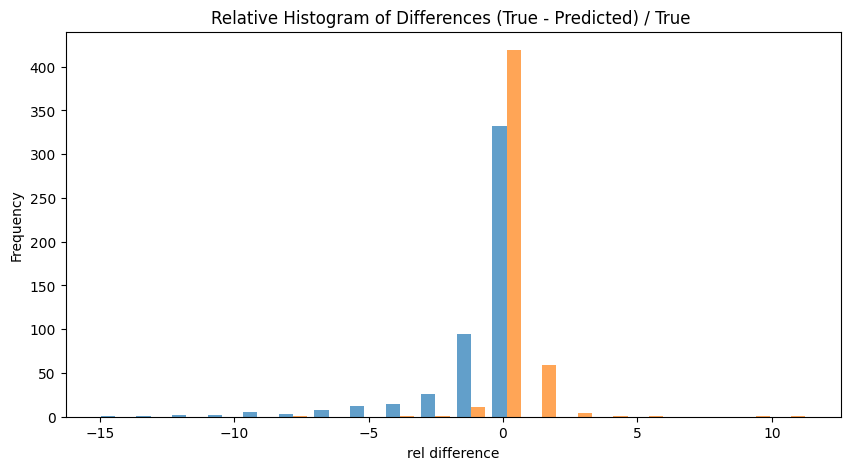

In [20]:
diffs = y_test - y_pred_test
relative_diffs = diffs / y_test
# histogram of the differences
plt.figure(figsize=(10, 5))
plt.hist(relative_diffs.numpy(), bins=20, alpha=0.7)
plt.title("Relative Histogram of Differences (True - Predicted) / True ")
plt.xlabel("rel difference")
plt.ylabel("Frequency")
plt.show() 

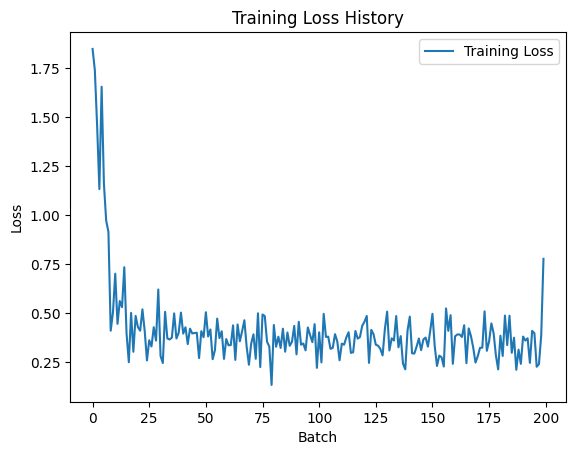

In [21]:
plt.plot(loss_hist, label="Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()


In [22]:
params_hist_nice = {
    key: np.array([i[key].detach().numpy() for i in params_hist])
    for key in params_hist[0].keys()
}
print(params_hist_nice.keys())

dict_keys(['positions', 'local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2', 'global_pulse_duration', 'local_pulse_duration', 'embed_pulse_duration', 'conv_params', '0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])


In [23]:
positions_hist = np.array([i["positions"].detach().numpy() for i in params_hist])
local_pulses_omega_1_hist = np.array([i["local_pulses_omega_1"].detach().numpy() for i in params_hist])
local_pulses_delta_1_hist = np.array([i["local_pulses_delta_1"].detach().numpy() for i in params_hist])

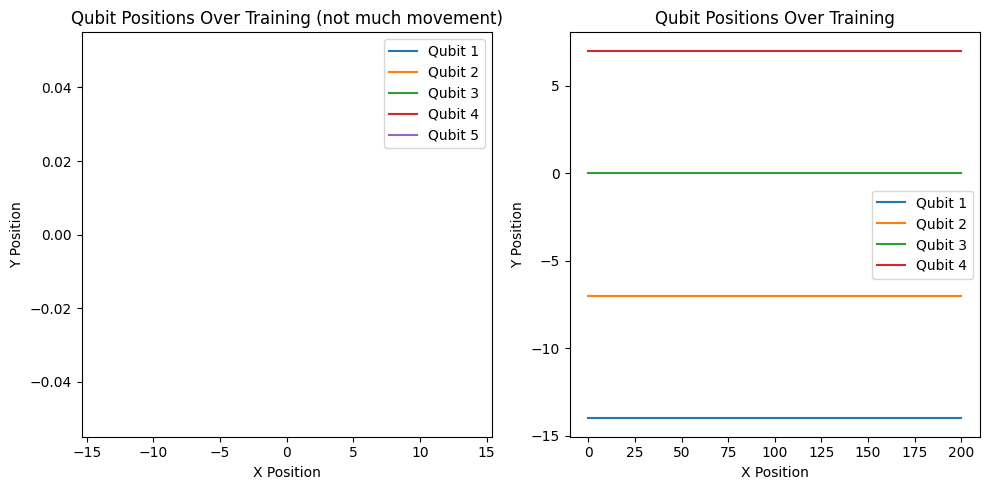

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
for qubit in range(positions_hist.shape[1]):
    plt.plot(positions_hist[:, qubit, 0], positions_hist[:, qubit, 1], label=f"Qubit {qubit+1}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training (not much movement)")
plt.legend()
plt.sca(axs[1])
# only first qubit
plt.plot(positions_hist[:, 0, 0], label="Qubit 1")
plt.plot(positions_hist[:, 1, 0], label="Qubit 2")
plt.plot(positions_hist[:, 2, 0], label="Qubit 3")
plt.plot(positions_hist[:, 3, 0], label="Qubit 4")
# plt.plot(positions_hist[:, 4, 0], label="Qubit 5")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training")
plt.legend()
plt.tight_layout()  
plt.show()  

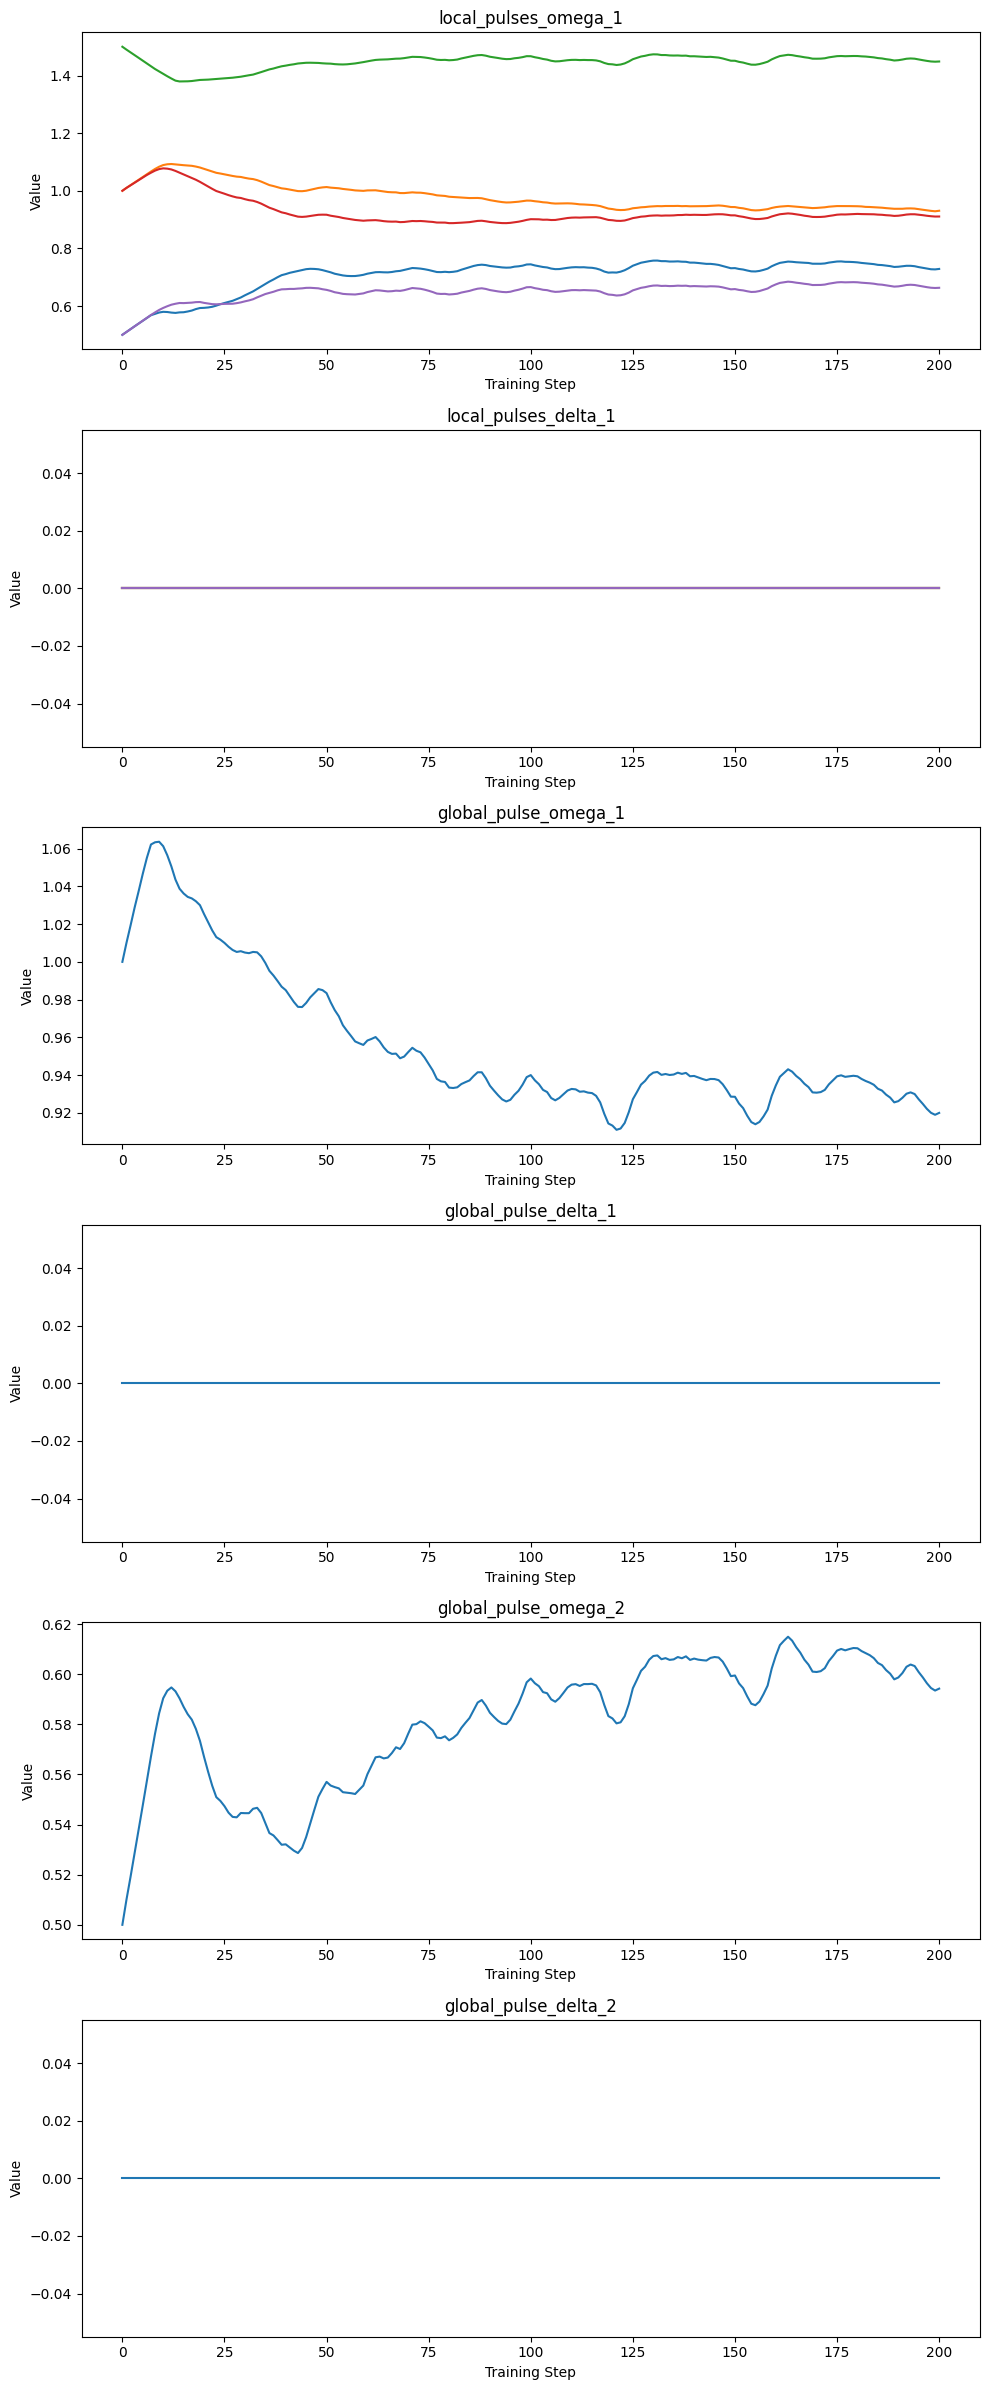

In [25]:
plot_keys = ['local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2']
fig, axs = plt.subplots(len(plot_keys), 1, figsize=(10, 4 * len(plot_keys)))
for i, key in enumerate(plot_keys):
    axs[i].plot(params_hist_nice[key])
    axs[i].set_title(key)
    axs[i].set_xlabel("Training Step")
    axs[i].set_ylabel("Value")
plt.tight_layout()
plt.show()  

In [26]:
import pickle

# number of learned parameters, i.e. with require_grad=True
NAHEA_CNN.train()
# number of parameters
n_params = sum(v.numel() for p, v in NAHEA_CNN.parameters().items() if v.requires_grad)
print(f"Number of trainable parameters: {n_params}")
# save training history
os.makedirs("losses_hist", exist_ok=True)
with open("losses_hist/NAHEA_CNN_GaussPeak_dist_grad_false_train_hist.pickle", "wb") as f:
    pickle.dump(
        {
            "loss_hist": loss_hist,
            "params_hist": params_hist,
            "hparams": hparams,
            loss_test.item(): "test_loss",
            "n_learned_parameters": n_params,
        },
        f,
    )

Number of trainable parameters: 166
